In [1]:
import sys
sys.path.append('../python')
from plot_info import *
from keras.models import Sequential
from keras.layers import Dense, Activation
import keras

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4
import os.path

input_size=40
train_size=128
validation_size=200
data_path='/run/media/klye/elements/kjetil/deleteme/kh_1.nc'

/usr/lib64/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:

class AreaFunctional(object):
    def __init__(self, integrate_coordinate = [0.55,0.35], integrate_width=[0.3,0.3],variable='rho'):
        self.integrate_coordinate = integrate_coordinate
        self.integrate_width = integrate_width
        
        self.variable = variable
    def area(self, I):
        
        return (I[0][1]-I[0][0])*(I[1][1]-I[1][0])
    def __call__(self, rho):
        N = rho.shape[0]
        
        integrate_area = [[int(N*self.integrate_coordinate[0]), int(N*self.integrate_coordinate[1])],
                          [int(N*self.integrate_coordinate[0]+N*self.integrate_width[0]), 
                           int(N*self.integrate_coordinate[1]+N*self.integrate_width[1])]]
        
        return sum(rho[integrate_area[0][0]:integrate_area[1][0], integrate_area[0][1]:integrate_area[1][1]])/self.area(integrate_area)
    
    
    def plot(self, d):
        N = d.shape[0]
        x, y= mgrid[0:1:N*1j,0:1:N*1j]
        plt.pcolormesh(x,y,d)
        rect = matplotlib.patches.Rectangle((self.integrate_coordinate[0],self.integrate_coordinate[0]),
                                     self.integrate_width[0],
                                     self.integrate_width[1],
                                     linewidth=1,edgecolor='r',facecolor='none')
        
        axes = plt.gca()
        axes.add_patch(rect)
        plt.show()
    
    

In [3]:
def get_samples(data_path, functional):
    samples = []
    
    with netCDF4.Dataset(data_path) as f:
        for k in f.variables.keys():
            if functional.variable in k:
                sys.stdout.write("%d\r" % len(samples))
                sys.stdout.flush()
                samples.append(functional(f.variables[k][:,:,0]))
    
    print()
    return array(samples)
def draw_functional(data_path, functional):
    with netCDF4.Dataset(data_path) as f:
        d = f.variables['sample_10_%s' % functional.variable][:,:,0]
        functional.plot(d)
        

                

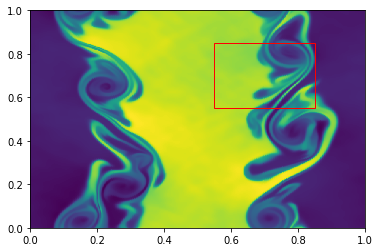

In [4]:
draw_functional(data_path, AreaFunctional())

In [5]:
def get_network_from_functional(data_path, functional, parameters):
    samples = get_samples(data_path, functional)
    return get_network(parameters, samples, train_size=train_size, validation_size=validation_size)
def get_network_from_functional_qmc(data_path, functional):
    parameter_path = os.path.join(os.path.dirname(data_path), 'qmc_points.txt')
    parameters = loadtxt(parameter_path)
    
    return get_network_from_functional(data_path, functional, parameters)
def get_network(parameters, data, *, train_size, validation_size, epochs=500000):
    input_size = parameters.shape[1]
    model = Sequential([
        Dense(20, input_shape=(input_size,)),
        Activation('relu'),
        Dense(22),
        Activation('relu'),
        Dense(20),
        Activation('relu'),
        Dense(22),
        Activation('relu'),
        Dense(20),
        Activation('relu'),
        Dense(20),
        Activation('relu'),
        Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.SGD(lr=0.01),
                  loss='mean_squared_error')
    x_train = parameters[:train_size,:]
  
    y_train=data[:train_size]
    
    
    x_val = parameters[train_size:validation_size+train_size,:]
    y_val=data[train_size:train_size+validation_size]
   
    epochs_r=range(1, epochs)
   
    hist = model.fit(x_train, y_train,batch_size=train_size, epochs=epochs,shuffle=True,
          validation_data=(x_val, y_val),verbose=0)
    plt.loglog(hist.history['loss'])
    plt.show()
    plt.loglog(hist.history['loss'][4:])
    plt.show()
    plt.loglog(hist.history['loss'][400:])
    plt.show()
    plt.loglog(hist.history['val_loss'])
    plt.show()
    plt.loglog(hist.history['val_loss'][4:])
    plt.show()
    plt.loglog(hist.history['val_loss'][400:])
    plt.show()
    x_test = parameters
    y_test = data
    y_predict = model.predict(x_test)
    print(y_test.shape)
    print(y_predict.shape)
    plt.scatter(y_test, y_predict[:,0])
    plt.xlabel("Actual data")
    plt.ylabel("Predicted data")
    plt.show()
    print(model.summary())
    print("Number of parameters: %d"% model.count_params())
    
    return  model, data, parameters

In [6]:
def get_network_interpolate_qmc(data_path, functional):
    draw_functional(data_path, functional)
    network, data, parameters = get_network_from_functional_qmc(data_path, functional)
    
    from sklearn import linear_model
    reg = linear_model.LinearRegression()
    y_train = data[:train_size]
    coeffs = reg.fit(parameters[:train_size,:], y_train)

    evaluated_lsq = coeffs.predict(parameters)
    plt.scatter(data, evaluated_lsq)
    plt.title('Least squares of degree 1')
    plt.xlabel("Actual data")
    plt.ylabel("Interpolated data")
    plt.show()
    
    def myvar(x):
        mean = sum(x)/x.shape[0]
        var = sum((mean-x)**2)/x.shape[0]
        return var
    
    def mymean (x): 
        return sum(x)/x.shape[0]
    
    
   
    
    variance_top = myvar(data)
    print("variance single level = %f" % variance_top)
    predicted = network.predict(parameters)
    predicted = predicted.reshape(parameters.shape[0])
    variance_diff_ml = myvar(data- predicted)
    
    
    print("variance diff ml = %f " % variance_diff_ml)
    print("speedup = %f" % (variance_top/variance_diff_ml/2.))
    print((data - evaluated_lsq).shape)
    variance_diff_interpolate =myvar(data - evaluated_lsq)
    print("variance_diff_interpolate = %f" % variance_diff_interpolate)
    
    mean_qmc = mymean(data)
    print("mean_qmc = %f" % mean_qmc)
    mean_ml = mymean(network.predict(parameters))
    print("mean_ml = %f" % mean_ml)
    mean_few_qmc = mymean(parameters[:train_size,:])
    
    print("mean_few_qmc = %f" % mean_few_qmc)
    print("mean_lsq = %f" % mean(evaluated_lsq))
    
    
    
    
    predicted_all = network.predict(parameters)
    predicted_all = predicted_all.reshape(parameters.shape[0])
    print(predicted_all.shape)
    mean_mlmlmc = mymean(predicted[:train_size]-data[:train_size]) + mymean(predicted_all)
    
    print("mean_mlmlmc = %f" % mean_mlmlmc)
    var_qmc = myvar(data)
    print("var_qmc = %f" % var_qmc)
    var_ml = myvar(network.predict(parameters))
    print("var_ml = %f" % var_ml)
    var_few_qmc = myvar(parameters[:train_size,:])
    
    print("var_few_qmc = %f" % var_few_qmc)
    print(parameters.shape)
    print("var_lsq = %f" % var(evaluated_lsq))
    
    
    plt.hist(data,bins=40,density=True,label='QMC 8192 samples',alpha=0.5)
    plt.title("Comparison QMC and Machine learning")
    plt.hist(network.predict(parameters),bins=40,density=True,label='ML(%d samples)' % train_size,alpha=0.5)
    plt.legend()
    showAndSave('hist_qmc_ml')
    
    
    plt.title("Comparison QMC with %d and QMC with %d samples" %(8192, train_size))
    plt.hist(data,bins=40,density=True,label='QMC 8192 samples',alpha=0.5)
    plt.hist(data[:train_size],bins=40,density=True, alpha=0.5,label='QMC %d samples' % train_size)
    plt.legend()
    showAndSave('hist_qmc_qmc')
    
    plt.title("Comparison QMC with least squares")
    plt.hist(data,bins=40,density=True,label='QMC 8192 samples',alpha=0.5)
    plt.hist(evaluated_lsq,bins=40,density=True,alpha=0.5, label='Least squares')
    plt.legend()
    showAndSave('hist_qmc_lsq')
    
    return network, data, parameters

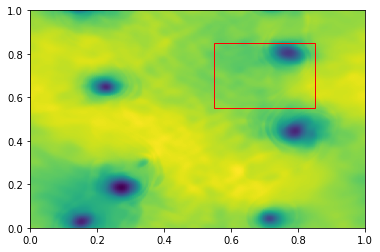

8191


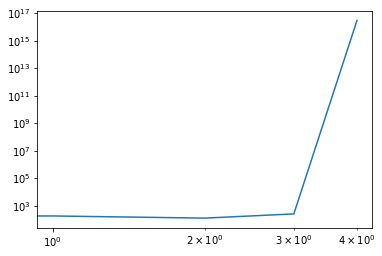

/u/klye/.local/lib/python3.6/site-packages/matplotlib/ticker.py:2207: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


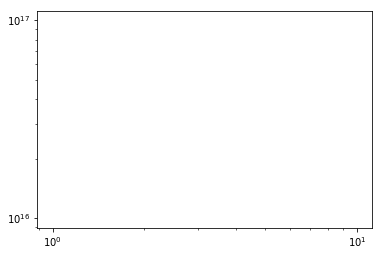

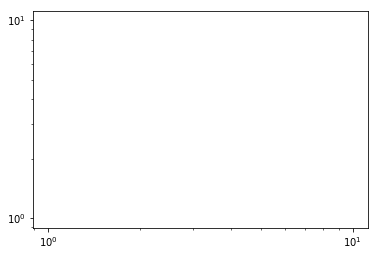

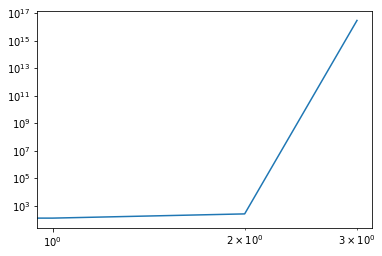

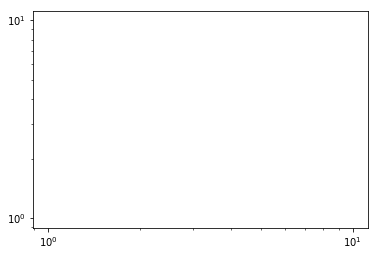

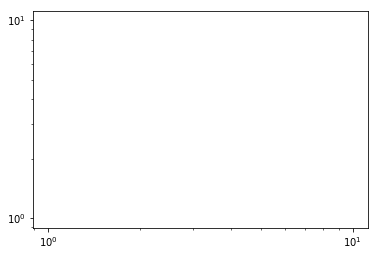

(8192,)
(8192, 1)


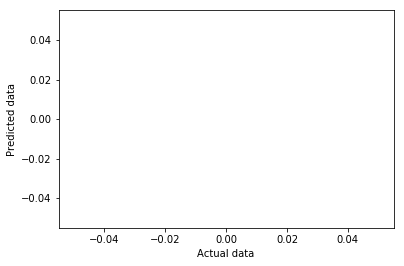

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                820       
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 22)                462       
_________________________________________________________________
activation_2 (Activation)    (None, 22)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                460       
_________________________________________________________________
activation_3 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 22)                462       
__________

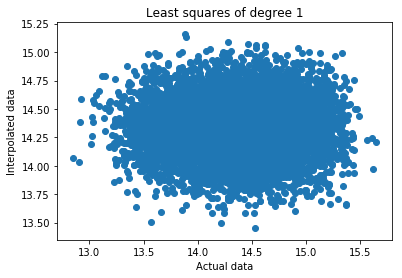

variance single level = 0.193405
variance diff ml = nan 
speedup = nan
(8192,)
variance_diff_interpolate = 0.250842
mean_qmc = 14.360292
mean_ml = nan
mean_few_qmc = 19.843750
mean_lsq = 14.329366
(8192,)
mean_mlmlmc = nan
var_qmc = 0.193405
var_ml = nan
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.057695


/u/klye/.local/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/u/klye/.local/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


ValueError: max must be larger than min in range parameter.

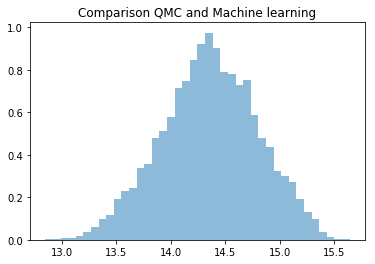

In [7]:
variables = ['E', 'rho', 'p']

points = [[0.55,0.35], [0.35,0.55], [0.0,0.0], [0.6,0.6]]

for v in variables:
    for p in points:
        prefix = '%s_%f_%f' % (v, p[0], p[1])
        prefix = prefix.replace('.','_')
        showAndSave.prefix = prefix
        
        network, data, parameters = get_network_interpolate_qmc(data_path, AreaFunctional(integrate_coordinate=p,variable=v))
        


In [ ]:
samples = get_samples(data_path, AreaFunctional())

In [ ]:
parameter_path = os.path.join(os.path.dirname(data_path), 'qmc_points.txt')
parameters = loadtxt(parameter_path)
from sklearn import linear_model
data = samples

print(data)
reg_size = 128
reg = linear_model.LinearRegression()
y_train = data[:reg_size]
coeffs = reg.fit(parameters[:reg_size,:], y_train)

evaluated_lsq = coeffs.predict(parameters)
plt.scatter(data, evaluated_lsq)
plt.title('Least squares of degree 1')
plt.xlabel("Actual data")
plt.ylabel("Interpolated data")
plt.show()
print(sum(evaluated_lsq)/len(evaluated_lsq))
print(sum(data)/len(data))
print(var(data))
print(var(evaluated_lsq))

In [ ]:
func=AreaFunctional()
with netCDF4.Dataset(data_path) as f:
    d = f.variables['sample_10_rho'][:,:,0]
    r = func(d)
    print(r)